## Empirical Bayes experiments - different datasets and prior weightings

### Step 0: packages

In [1]:
# test modification

library(data.table)
library(tidyverse)
library(distr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: startupmsg

Utilities for Start-Up Messages (version 0.9.6)

For more information see ?"startupmsg", NEWS("startupmsg")


Loading required package: sfsmisc


Attaching package: ‘sfsmisc’


The following object is masked from ‘package:dplyr’:

    last


The following object is masked from ‘package:data.table’:

    last


Object Oriented Implementation of Distributions (version 2.8.0)



### Step 1: load in the data and split it into train and test sets

In [2]:
# raw_df = read.csv("data/Gift_Cards.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
# raw_df = read.csv("data/Video_Games_raw.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
raw_df = read.csv("data/Prime_Pantry.csv", header = FALSE, col.names=c("item", "user", "rating", "timestamp"))
head(raw_df)

set.seed(1729)

df <- raw_df %>% 
  select(c("item", "rating"))

counts <- count(df, item) %>%
  filter(n > 20)

df = merge(counts, df, by="item")
in.train = sample(unique(df$item), size = 0.6*length(unique(df$item)))
df.train = filter(df, item %in% in.train)
df.test = filter(df, !item %in% in.train)

,item,user,rating,timestamp
,<chr>,<chr>,<dbl>,<int>
1,B0000DIWNZ,A1NKJW0TNRVS7O,5,1418515200
2,B0000DIWNZ,A2L6X37E8TFTCC,4,1416441600
3,B0000DIWNZ,A2WPR4W6V48121,4,1412985600
4,B0000DIWNZ,A27EE7X7L29UMU,3,1409529600
5,B0000DIWNZ,A1OWT4YZGB5GV9,4,1407628800
6,B0000DIWNZ,A1GN2ADKF1IE7K,5,1405296000


### Step 2: Train the EB model (categorical with Dirichlet prior)

In [3]:
prior_df <- dcast(setDT(df.train), item ~ rating, fun.aggregate = length)

colnames(prior_df) <- c("item", "n1", "n2", "n3", "n4", "n5")

prior_df$n = prior_df$n1 + prior_df$n2 + prior_df$n3 + prior_df$n4 + prior_df$n5

prior_df <- filter(prior_df, n > 20)

# remove all columns with a 0 count for one category
prior_df  <- transmute(prior_df, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n) %>% 
  filter(n1 != 0 & n2 != 0 & n3 != 0 & n4 != 0 & n5 != 0)

log_p <- summarize(prior_df, summarize(prior_df, n1 = sum(log(n1)), n2 = sum(log(n2)), n3 = sum(log(n3)), n4=sum(log(n4)), n5=sum(log(n5))))
log_p <- as.numeric(log_p[1,])

print(log_p)
# gift cards log-p: -558.81647 -798.35765 -708.34644 -518.60578  -36.76743
# video games log-p: -19110.579 -23947.009 -20340.458 -15104.914  -5944.121
# prime pantry log-p: -5113.2916 -5570.4004 -4816.4874 -3816.7264  -770.3125

N <- nrow(prior_df)

# start from a totally uninformed prior
alphas = c(1,1,1,1,1)

# actual training function

fp_step <- function(alphas, log_p, N) {
  return(igamma(rep(digamma(sum(alphas)), 5) + log_p/N))
}

[1] -5113.2916 -5570.4004 -4816.4874 -3816.7264  -770.3125


In [4]:
# this step must be repeated many times.
# gift card alphas: 18.41389   4.77803   7.56642  21.55294 309.98082
# video game alphas: 2.026083 1.318121 1.806632 3.009980 8.200924
# prime pantry alphas: 2.360188  1.927949  2.705008  4.389483 22.445298
alphas <- fp_step(alphas, log_p, N)
b = sum(alphas)
print(alphas)

[1] 0.6506952 0.5774921 0.7066582 0.9632674 3.4104034


In [5]:
# check if stability achieved

for (i in c(1:100)) {
    alphas <- fp_step(alphas,log_p,N)
}
print(alphas)

[1]  2.360188  1.927949  2.705008  4.389483 22.445298


### Step 3: Prepare the various testing methods

In [14]:
temp = filter(raw_df, item %in% df.test$item)
df.test <- merge(counts, temp, by="item")

df.test <- filter(df.test, n >= 100) %>%
  group_by(item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=100)

#split test set in half
df.test_learn = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_head(n=50)
df.test_eval = group_by(df.test, item) %>% 
  arrange(timestamp, .by_group = TRUE) %>%
  slice_tail(n=50)

# set up evaluation dataset for evaluating
df.test_eval <- dcast(setDT(df.test_eval), item ~ rating, fun.aggregate = length) %>% arrange(item)
colnames(df.test_eval) <- c("item", "n1", "n2", "n3", "n4", "n5")
df.test_eval$n = df.test_eval$"n1" + df.test_eval$"n2" + df.test_eval$"n3" + df.test_eval$"n4" + df.test_eval$"n5"
df.test_eval <- transmute(df.test_eval, item=item, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)

num_eval_products = nrow(df.test_eval)

#### Step 3.1 - Over-time test of EB compared with frequentist

In [11]:
# start training and checking performance at each step
items = unique(df.test_learn$item)

mses_f = tibble(items)
mses_b = tibble(items)
kls_f = tibble(items)
kls_b = tibble(items)

for (i in c(1:50)) {
  df.test_learn_subset = group_by(df.test_learn, item) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    slice_head(n=i)

  df.test_learn_subset <- dcast(setDT(df.test_learn_subset), item ~ rating, fun.aggregate = length, drop=FALSE) %>% arrange(item)
  
  # adding missing columns
  for (j in setdiff(c("item", "1", "2", "3", "4", "5"), colnames(df.test_learn_subset))) {
    df.test_learn_subset[[j]] <- rep(0, num_eval_products)
  }
  df.test_learn_subset <- df.test_learn_subset[,c("item", "1", "2", "3", "4", "5")]
  
  colnames(df.test_learn_subset) <- c("item", "n1", "n2", "n3", "n4", "n5")
  df.test_learn_subset$n = df.test_learn_subset$"n1" + df.test_learn_subset$"n2" + df.test_learn_subset$"n3" + df.test_learn_subset$"n4" + df.test_learn_subset$"n5"

  df.test_learn_f <- transmute(df.test_learn_subset, item=item, avg = (n1+n2*2+n3*3+n4*4+n5*5)/n, n1 = n1 / n, n2 = n2 / n, n3 = n3 / n, n4 = n4 / n, n5 = n5 / n)
  df.test_learn_b <- mutate(df.test_learn_subset, item=item, b1 = n1 + alphas[1], b2 = n2 + alphas[2], b3 = n3 + alphas[3],
         b4 = n4 + alphas[4], b5 = n5 + alphas[5], b = n + sum(alphas))
  df.test_learn_b <- transmute(df.test_learn_b, item=item, avg = (b1+b2*2+b3*3+b4*4+b5*5)/n, b1 = b1 / b, b2 = b2 / b, b3 = b3 / b, b4 = b4 / b, b5 = b5 / b)
    
  df.test_learn_f <- df.test_learn_f %>% select(-c(item, avg))
  df.test_learn_b <- df.test_learn_b %>% select(-c(item, avg))
    
  df.test_eval_modified <- select(df.test_eval, -c(item))

  f_mse = rowSums((df.test_learn_f - df.test_eval_modified)^2)
  b_mse = rowSums((df.test_learn_b - df.test_eval_modified)^2)
  f_kl = rowSums(df.test_eval_modified*log(df.test_eval/df.test_learn_f), na.rm = TRUE)
  f_kl[!is.finite(f_kl)] = 1
  b_kl = rowSums(df.test_eval_modified*log(df.test_eval/df.test_learn_b), na.rm = TRUE)
  b_kl[!is.finite(b_kl)] = 1
  
  mses_f[[i]] = f_mse
  mses_b[[i]] = b_mse
  kls_f[[i]] = f_kl
  kls_b[[i]] = b_kl

}

mses_f = tibble(val = colSums(mses_f) / num_eval_products, method = "freq", idx=c(1:length(mses_f)))
mses_b = tibble(val = colSums(mses_b) / num_eval_products, method = "eb", idx=c(1:length(mses_b)))
kls_f = tibble(val = colSums(kls_f) / num_eval_products, method = "freq", idx=c(1:length(kls_f)))
kls_b = tibble(val = colSums(kls_b) / num_eval_products, method = "eb", idx=c(1:length(kls_b)))

mses = rbind(mses_f,mses_b)
kls = rbind(kls_f,kls_b)

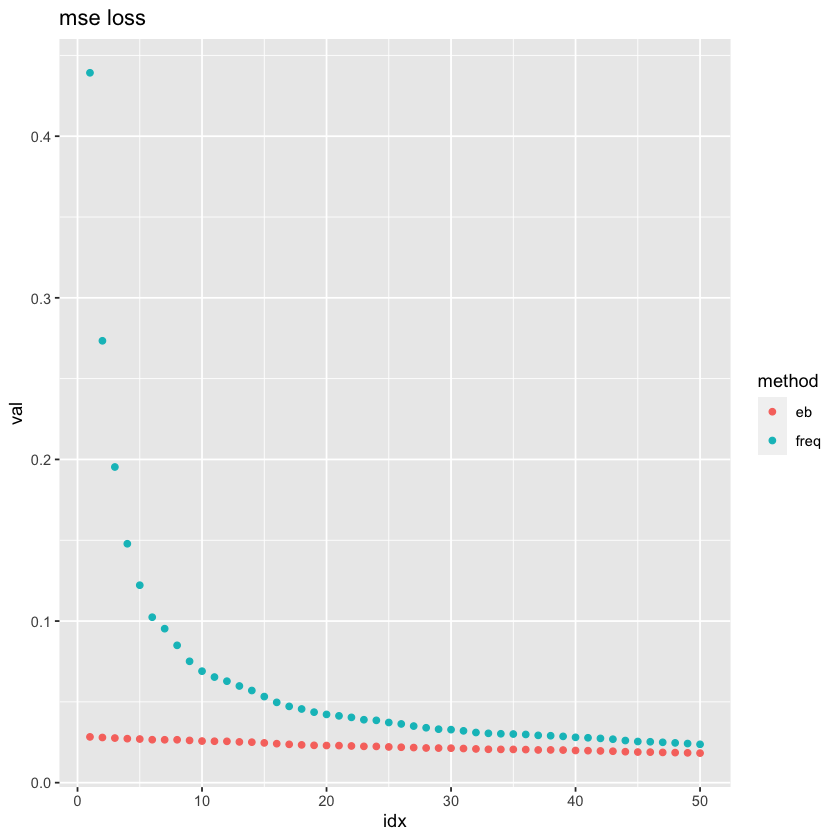

In [10]:
# Plot MSE loss

ggplot(mses, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("mse loss")

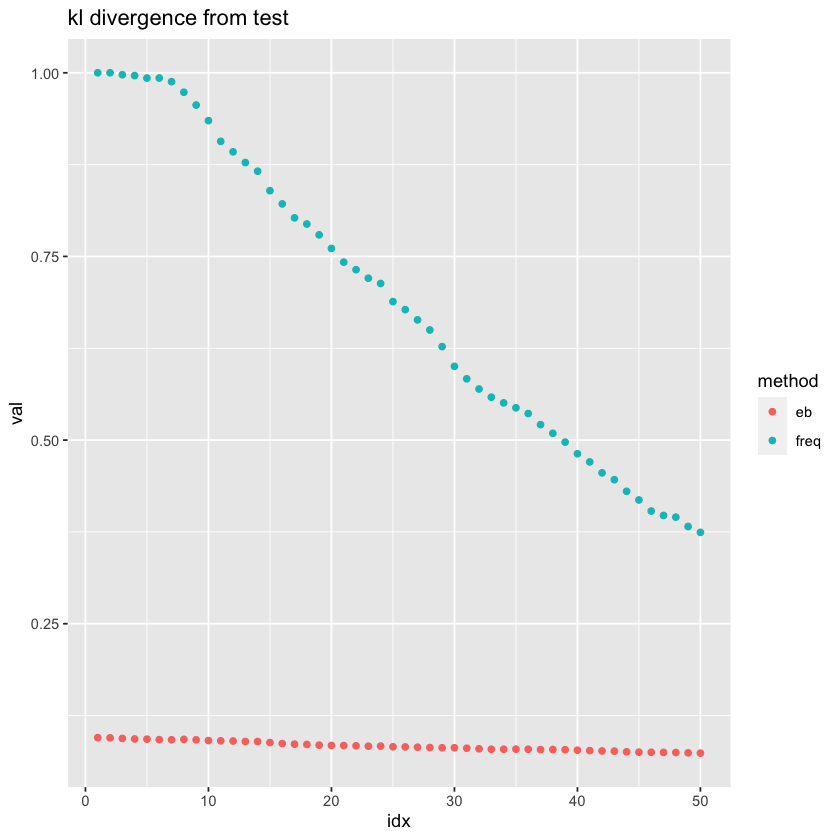

In [11]:
# Plot kl divergence

ggplot(kls, aes(x=idx, y=val, color=method)) +
  geom_point() +
  ggtitle("kl divergence from test")

#### Step 3.2 Facet grid of MSE loss over train sample stratified by average rating

In [62]:
test_eval_subset = df.test_eval %>% mutate(avg = n1+2*n2+3*n3+4*n4+5*n5)

In [63]:
test_eval_subset

item,n1,n2,n3,n4,n5,avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B00032E8XK,0.14,0.04,0.10,0.20,0.52,3.92
B00099XNXS,0.08,0.02,0.06,0.12,0.72,4.38
B000OUYN5Y,0.08,0.02,0.00,0.12,0.78,4.50
B000PUIPXO,0.14,0.04,0.02,0.16,0.64,4.12
B000QCPNZY,0.00,0.04,0.06,0.06,0.84,4.70
B000QSTKFC,0.04,0.02,0.04,0.08,0.82,4.62
B000R4M8GI,0.02,0.08,0.08,0.14,0.68,4.38
B000R738KU,0.04,0.04,0.16,0.16,0.60,4.24
B000R73YR2,0.02,0.00,0.04,0.10,0.84,4.74


In [64]:
set.seed(1729)

test_eval_subset_1 <- test_eval_subset %>% filter(avg <= 2)
test_eval_subset_1 <- test_eval_subset_1 %>% sample_n(min(10, nrow(test_eval_subset_1)))
test_eval_subset_2 <- test_eval_subset %>% filter(avg <= 3, avg > 2)
test_eval_subset_2 <- test_eval_subset_2 %>% sample_n(min(10, nrow(test_eval_subset_2)))
test_eval_subset_3 <- test_eval_subset %>% filter(avg <= 4, avg > 3)
test_eval_subset_3 <- test_eval_subset_3 %>% sample_n(min(10, nrow(test_eval_subset_3)))
test_eval_subset_4 <- test_eval_subset %>% filter(avg > 4)
test_eval_subset_4 <- test_eval_subset_4 %>% sample_n(min(10, nrow(test_eval_subset_4)))

test_eval_subset <- rbind(test_eval_subset_1, test_eval_subset_2, test_eval_subset_3, test_eval_subset_4)

In [56]:
test_eval_subset

item,n1,n2,n3,n4,n5,avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B00I8YKP28,0.36,0.18,0.08,0.00,0.38,2.86
B000YG3LT2,0.28,0.20,0.16,0.04,0.32,2.92
B00ZBK34F2,0.30,0.08,0.22,0.12,0.28,3.00
B000WLJINM,0.48,0.08,0.04,0.16,0.24,2.60
B014F3OYCC,0.34,0.18,0.06,0.12,0.30,2.86
B00UB6ZL0W,0.42,0.14,0.08,0.06,0.30,2.68
B01B5Q8L30,0.14,0.10,0.18,0.12,0.46,3.66
B00032E8XK,0.14,0.04,0.10,0.20,0.52,3.92
B010CQV32A,0.20,0.14,0.08,0.08,0.50,3.54


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



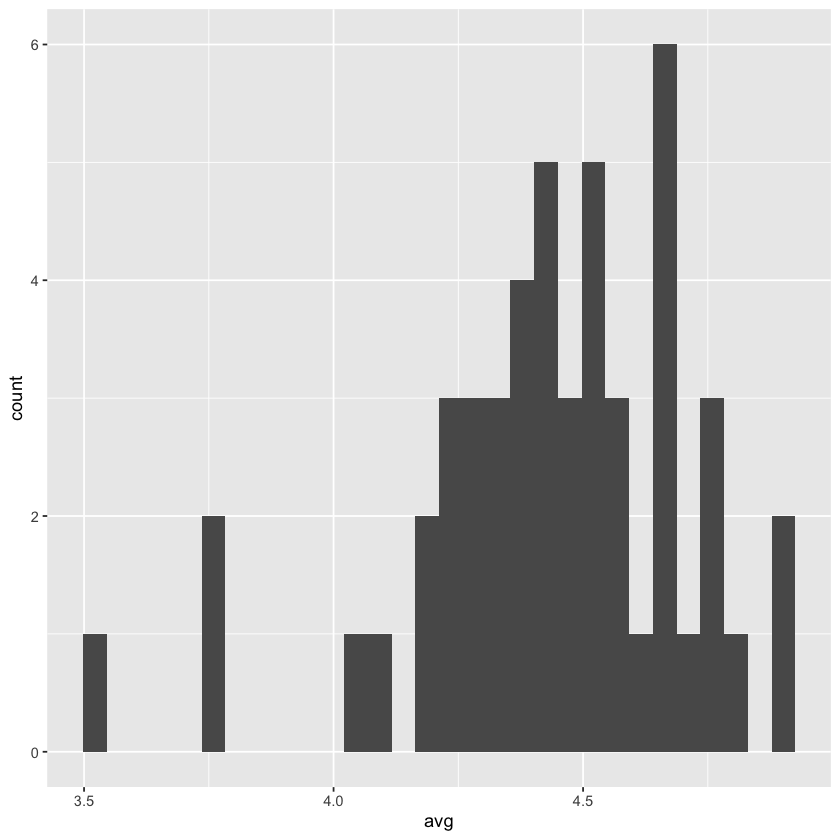

In [26]:
ggplot(test_eval_subset, aes(x=avg)) +
    geom_histogram()